<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
!wget --header="Host: doc-0o-bk-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_nso6dcn1mbidkt5qr539a2jiefc09pqv_nonce=iak2ig7rpq664" --header="Connection: keep-alive" "https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/nss2f5s2soorprev6d4t4qp3n5ekp9nh/evl2j2j4t5hronicnhsbdlsblnbl9qk3/1622116650000/06629147635963609455/13017565264516993811/1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV?e=download&authuser=0&nonce=iak2ig7rpq664&user=13017565264516993811&hash=fvl5s6dohfnqle6k8q3koe9jr2mhe6jr" -c -O 'storage_sample_stage4.h5'

--2022-06-08 14:16:37--  https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/nss2f5s2soorprev6d4t4qp3n5ekp9nh/evl2j2j4t5hronicnhsbdlsblnbl9qk3/1622116650000/06629147635963609455/13017565264516993811/1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV?e=download&authuser=0&nonce=iak2ig7rpq664&user=13017565264516993811&hash=fvl5s6dohfnqle6k8q3koe9jr2mhe6jr
Resolving doc-0o-bk-docs.googleusercontent.com (doc-0o-bk-docs.googleusercontent.com)... 142.250.183.97
Connecting to doc-0o-bk-docs.googleusercontent.com (doc-0o-bk-docs.googleusercontent.com)|142.250.183.97|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2022-06-08 14:16:38 ERROR 403: Forbidden.



In [3]:
#reading
from pandas import read_hdf
df_finalTrain = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [4]:
df_finalTrain.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [5]:
Ytrain = df_finalTrain.indicator_link
y_test = df_final_test.indicator_link

In [6]:
df_finalTrain.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9063252121775113 test Score 0.8745605278006858
Estimators =  50 Train Score 0.9205725512208812 test Score 0.9125653355634538
Estimators =  100 Train Score 0.9238690848446947 test Score 0.9141199714153599
Estimators =  250 Train Score 0.9239789348046863 test Score 0.9188007232664732
Estimators =  450 Train Score 0.9237190618658074 test Score 0.9161507685828595


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

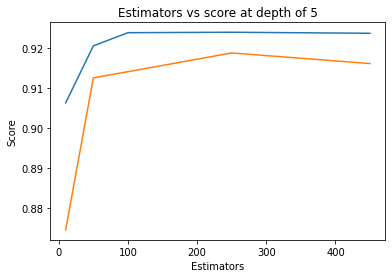

In [7]:
estimators = [10,50,100,250,450]
trainScores = []
testScores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            #min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_finalTrain,Ytrain)
    train_sc = f1_score(Ytrain,clf.predict(df_finalTrain))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    testScores.append(test_sc)
    trainScores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,trainScores,label='Train Score')
plt.plot(estimators,testScores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8916120853581238 test Score 0.8687934859875491
depth =  9 Train Score 0.9572226298198419 test Score 0.9222953031452904
depth =  11 Train Score 0.9623451340902863 test Score 0.9252318758281279
depth =  15 Train Score 0.9634267621927706 test Score 0.9231288356496615
depth =  20 Train Score 0.9631629153051491 test Score 0.9235051024711141
depth =  35 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  50 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  70 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  130 Train Score 0.9634333127085721 test Score 0.9235601652753184


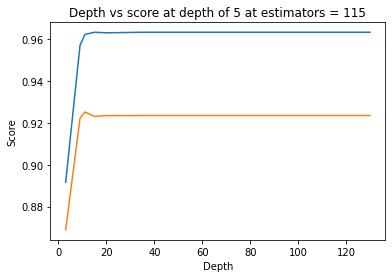

In [8]:
depths = [3,9,11,15,20,35,50,70,130]
trainScores = []
testScores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            #min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_finalTrain,Ytrain)
    train_sc = f1_score(Ytrain,clf.predict(df_finalTrain))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    testScores.append(test_sc)
    trainScores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,trainScores,label='Train Score')
plt.plot(depths,testScores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [9]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

paramDist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=paramDist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_finalTrain,Ytrain)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96225042 0.96215492 0.9605708  0.96194014 0.96330005]


In [10]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [11]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, #min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [12]:
clf.fit(df_finalTrain,Ytrain)
Ytrain_pred = clf.predict(df_finalTrain)
y_test_pred = clf.predict(df_final_test)

In [13]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(Ytrain,Ytrain_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9652533106548414
Test f1 score 0.9241678239279553


In [14]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


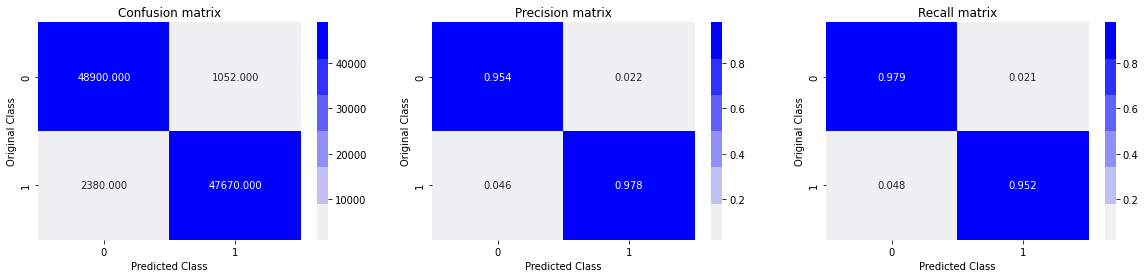

Test confusion_matrix


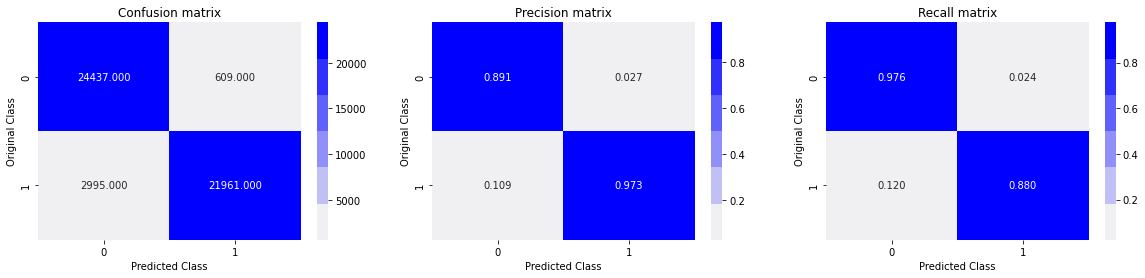

In [15]:
print('Train confusion_matrix')
plot_confusion_matrix(Ytrain,Ytrain_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

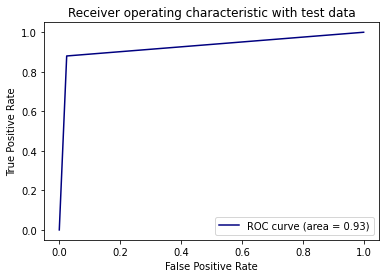

In [16]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

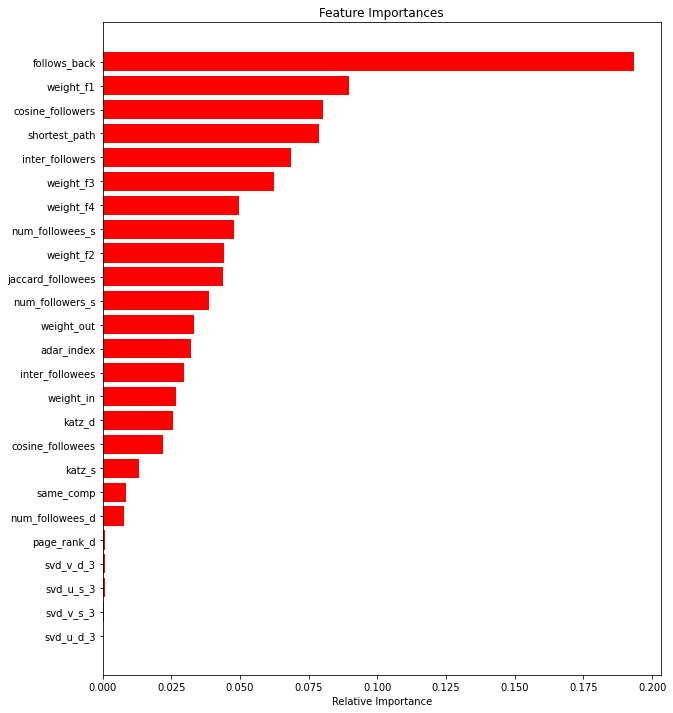

In [17]:
features = df_finalTrain.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

In [18]:
df_finalTrain.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,...,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14
1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,...,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09
2,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,...,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19
3,0,0.000000,0.000000,0.000000,11,5,7,0,0,0.000000,...,6.058498e-11,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13
4,0,0.000000,0.000000,0.000000,1,11,3,0,0,0.000000,...,1.197283e-07,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [19]:
df_final_test.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,0,0.0,0.029161,0.000000,14,6,9,1,0,0.000000,...,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12
1,0,0.0,0.000000,0.000000,17,1,19,0,0,0.000000,...,2.545382e-10,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14
2,0,0.0,0.000000,0.000000,10,16,9,0,0,0.000000,...,1.122150e-05,1.778927e-12,2.740535e-13,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14
3,0,0.0,0.000000,0.000000,37,10,34,0,0,0.000000,...,5.223676e-06,7.917166e-13,4.020707e-12,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13
4,0,0.2,0.042767,0.347833,27,15,27,4,7,6.136433,...,1.035016e-06,1.361574e-13,1.154623e-12,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13


Computing num_follwers_d

In [21]:
train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

In [6]:
from tqdm import tqdm
def compute_features_stage1(df,graph):
    num_followers_s =[]
    num_followees_s =[]
    num_followers_d =[]
    num_followees_d = []
    inter_followers= []
    inter_followees =[]
    for i,row in tqdm(df.iterrows()):  
        try:
            s1 = set(graph.predecessors(row['source_node']))
            s2 = set(graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
            
        try: 
            d1 = set(graph.predecessors(row["destination_node"]))
            d2 = set(graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))
        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followees.append(len(s1.intersection(d1)))
        inter_followers.append(len(s2.intersection(d2)))
        inter_followees.append(len(d1.intersection(s1)))
        inter_followers.append(len(d2.intersection(s2)))

        return num_followers_d,num_followees_d,num_followers_s,num_followees_s,inter_followers,inter_followees

In [7]:
train_num_followers_d,train_num_followees_d,train_num_followers_s,train_num_followees_s,train_inter_followers,train_inter_followees = compute_features_stage1(df_finalTrain,train_graph)
test_num_followers_d,test_num_followees_d,test_num_followers_s,test_num_followees_s,test_inter_followers,test_inter_followees = compute_features_stage1(df_final_test,test_graph)

NameError: name 'df_finalTrain' is not defined

In [32]:
len(train_num_followers_d)

1

In [33]:
len(test_num_followers_d)


1

In [ ]:
from itertools import zip_longest
def 

In [39]:
df_finalTrain["num_followers_d"] = train_num_followers_d
#df_finalTrain[]
df_finalTrain.head()

ValueError: Length of values (1) does not match length of index (100002)

In [4]:
import pandas as pd
pd.Index.size!=len(train_num_followers_d)

NameError: name 'train_num_followers_d' is not defined

In [5]:
df_final_test['num_followers_d'] = test_num_followees_d
df_final_test.head()

NameError: name 'test_num_followees_d' is not defined

# Preferential Attachments
For followers/

In [31]:
source = np.array(df_finalTrain["num_followers_s"])
destination = np.array(df_finalTrain["num_followers_d"])
followers_preferential = []
for i in range(len(source)):
    followers_preferential.append(source[i]*destination[i])
    df_finalTrain["followers_preferential_attach"]  = followers_preferential 
    df_finalTrain.head()

KeyError: 'num_followers_d'

In [42]:
source = np.array(df_finalTrain["num_followees_s"])
destination = np.array(df_finalTrain["num_followees_s"])
followees_preferential = []
for i in range(len(source)):
    followees_preferential.append(source[i]*destination[i])
df_finalTrain["followees_preferential_attach"]  = followees_preferential 
df_finalTrain.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,followees_preferential_attach
0,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,...,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,225
1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,...,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,3721
2,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,...,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,1681
3,0,0.000000,0.000000,0.000000,11,5,7,0,0,0.000000,...,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,25
4,0,0.000000,0.000000,0.000000,1,11,3,0,0,0.000000,...,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,121


In [43]:
source = np.array(df_final_test["num_followers_s"])
destination = np.array(df_final_test["num_followers_d"])
followers_preferential = []
for i in range(len(source)):
    followers_preferential.append(source[i]*destination[i])
df_final_test["followers_preferential_attach"]  = followers_preferential 
df_final_test.head()

KeyError: 'num_followers_d'

In [44]:
source = np.array(df_final_test["num_followees_s"])
destination = np.array(df_final_test["num_followees_s"])
followees_preferential = []
for i in range(len(source)):
    followees_preferential.append(source[i]*destination[i])
df_final_test["followees_preferential_attach"]  = followees_preferential 
df_final_test.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,followees_preferential_attach
0,0,0.0,0.029161,0.000000,14,6,9,1,0,0.000000,...,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,36
1,0,0.0,0.000000,0.000000,17,1,19,0,0,0.000000,...,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,1
2,0,0.0,0.000000,0.000000,10,16,9,0,0,0.000000,...,1.778927e-12,2.740535e-13,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,256
3,0,0.0,0.000000,0.000000,37,10,34,0,0,0.000000,...,7.917166e-13,4.020707e-12,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,100
4,0,0.2,0.042767,0.347833,27,15,27,4,7,6.136433,...,1.361574e-13,1.154623e-12,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,225


adding SV_DOT feature

In [46]:
sorted(df_finalTrain.columns)

['adar_index',
 'authorities_d',
 'authorities_s',
 'cosine_followees',
 'cosine_followers',
 'followees_preferential_attach',
 'follows_back',
 'hubs_d',
 'hubs_s',
 'inter_followees',
 'inter_followers',
 'jaccard_followees',
 'jaccard_followers',
 'katz_d',
 'katz_s',
 'num_followees_d',
 'num_followees_s',
 'num_followers_s',
 'page_rank_d',
 'page_rank_s',
 'same_comp',
 'shortest_path',
 'svd_u_d_1',
 'svd_u_d_2',
 'svd_u_d_3',
 'svd_u_d_4',
 'svd_u_d_5',
 'svd_u_d_6',
 'svd_u_s_1',
 'svd_u_s_2',
 'svd_u_s_3',
 'svd_u_s_4',
 'svd_u_s_5',
 'svd_u_s_6',
 'svd_v_d_1',
 'svd_v_d_2',
 'svd_v_d_3',
 'svd_v_d_4',
 'svd_v_d_5',
 'svd_v_d_6',
 'svd_v_s_1',
 'svd_v_s_2',
 'svd_v_s_3',
 'svd_v_s_4',
 'svd_v_s_5',
 'svd_v_s_6',
 'weight_f1',
 'weight_f2',
 'weight_f3',
 'weight_f4',
 'weight_in',
 'weight_out']

In [47]:
svd_dot_U =[]
range_value = len(np.array(df_finalTrain["svd_u_d_1"]))
for i in range(range_value):
    u_s = []
    u_d = []
    u_s.append(np.array(df_finalTrain["svd_u_s_1"][i]))
    u_s.append(np.array(df_finalTrain["svd_u_s_2"][i]))
    u_s.append(np.array(df_finalTrain["svd_u_s_3"][i]))
    u_s.append(np.array(df_finalTrain["svd_u_s_4"][i]))
    u_s.append(np.array(df_finalTrain["svd_u_s_5"][i]))
    u_s.append(np.array(df_finalTrain["svd_u_s_6"][i]))

    u_d.append(np.array(df_finalTrain["svd_u_d_1"][i]))
    u_d.append(np.array(df_finalTrain["svd_u_d_2"][i]))
    u_d.append(np.array(df_finalTrain["svd_u_d_3"][i]))
    u_d.append(np.array(df_finalTrain["svd_u_d_4"][i]))
    u_d.append(np.array(df_finalTrain["svd_u_d_5"][i]))
    u_d.append(np.array(df_finalTrain["svd_u_d_6"][i]))

    svd_dot_U.append(np.dot(u_s,u_d))

In [48]:
df_finalTrain["svd_dot_U"] = svd_dot_U
df_finalTrain.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,followees_preferential_attach,svd_dot_U
0,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,...,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,225,1.114958e-11
1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,...,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,3721,3.192812e-03
2,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,...,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,1681,1.787503e-35
3,0,0.000000,0.000000,0.000000,11,5,7,0,0,0.000000,...,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,25,4.710376e-20
4,0,0.000000,0.000000,0.000000,1,11,3,0,0,0.000000,...,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,121,7.773952e-14


In [51]:
svd_dot_V = []
range_value = len(np.array(df_finalTrain["svd_v_d_1"]))
for i in range(range_value):
    v_s = []
    v_d = []
    v_s.append(np.array(df_finalTrain["svd_v_s_1"][i]))
    v_s.append(np.array(df_finalTrain["svd_v_s_2"][i]))
    v_s.append(np.array(df_finalTrain["svd_v_s_3"][i]))
    v_s.append(np.array(df_finalTrain["svd_v_s_4"][i]))
    v_s.append(np.array(df_finalTrain["svd_v_s_5"][i]))
    v_s.append(np.array(df_finalTrain["svd_v_s_6"][i]))

    v_d.append(np.array(df_finalTrain["svd_v_d_1"][i]))
    v_d.append(np.array(df_finalTrain["svd_v_d_2"][i]))
    v_d.append(np.array(df_finalTrain["svd_v_d_3"][i]))
    v_d.append(np.array(df_finalTrain["svd_v_d_4"][i]))
    v_d.append(np.array(df_finalTrain["svd_v_d_5"][i]))
    v_d.append(np.array(df_finalTrain["svd_v_d_6"][i]))
    svd_dot_V.append(np.dot(v_s,v_d))

In [52]:
df_finalTrain["svd_dot_V"] = svd_dot_V
df_finalTrain.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,followees_preferential_attach,svd_dot_U,svd_dot_V
0,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,...,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,225,1.114958e-11,2.238775e-12
1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,...,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,3721,3.192812e-03,9.068719e-04
2,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,...,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,1681,1.787503e-35,2.467873e-36
3,0,0.000000,0.000000,0.000000,11,5,7,0,0,0.000000,...,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,25,4.710376e-20,3.159386e-18
4,0,0.000000,0.000000,0.000000,1,11,3,0,0,0.000000,...,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,121,7.773952e-14,0.000000e+00


In [54]:
svd_dot_U =[]
range_value = len(np.array(df_final_test["svd_u_d_1"]))
for i in range(range_value):
    u_s = []
    u_d = []
    u_s.append(np.array(df_final_test["svd_u_s_1"][i]))
    u_s.append(np.array(df_final_test["svd_u_s_2"][i]))
    u_s.append(np.array(df_final_test["svd_u_s_3"][i]))
    u_s.append(np.array(df_final_test["svd_u_s_4"][i]))
    u_s.append(np.array(df_final_test["svd_u_s_5"][i]))
    u_s.append(np.array(df_final_test["svd_u_s_6"][i]))

    u_d.append(np.array(df_final_test["svd_u_d_1"][i]))
    u_d.append(np.array(df_final_test["svd_u_d_2"][i]))
    u_d.append(np.array(df_final_test["svd_u_d_3"][i]))
    u_d.append(np.array(df_final_test["svd_u_d_4"][i]))
    u_d.append(np.array(df_final_test["svd_u_d_5"][i]))
    u_d.append(np.array(df_final_test["svd_u_d_6"][i]))

    svd_dot_U.append(np.dot(u_s,u_d))
  

In [55]:
df_final_test["svd_dot_U"] = svd_dot_U
df_final_test.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,followees_preferential_attach,svd_dot_U
0,0,0.0,0.029161,0.000000,14,6,9,1,0,0.000000,...,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,36,8.425267e-20
1,0,0.0,0.000000,0.000000,17,1,19,0,0,0.000000,...,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,1,1.352160e-17
2,0,0.0,0.000000,0.000000,10,16,9,0,0,0.000000,...,2.740535e-13,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,256,3.671980e-13
3,0,0.0,0.000000,0.000000,37,10,34,0,0,0.000000,...,4.020707e-12,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,100,1.634044e-10
4,0,0.2,0.042767,0.347833,27,15,27,4,7,6.136433,...,1.154623e-12,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,225,1.246700e-11


In [57]:
svd_dot_V = []
range_value = len(np.array(df_final_test["svd_v_d_1"]))
for i in range(range_value):
    v_s = []
    v_d = []
    v_s.append(np.array(df_final_test["svd_v_s_1"][i]))
    v_s.append(np.array(df_final_test["svd_v_s_2"][i]))
    v_s.append(np.array(df_final_test["svd_v_s_3"][i]))
    v_s.append(np.array(df_final_test["svd_v_s_4"][i]))
    v_s.append(np.array(df_final_test["svd_v_s_5"][i]))
    v_s.append(np.array(df_final_test["svd_v_s_6"][i]))

    v_d.append(np.array(df_final_test["svd_v_d_1"][i]))
    v_d.append(np.array(df_final_test["svd_v_d_2"][i]))
    v_d.append(np.array(df_final_test["svd_v_d_3"][i]))
    v_d.append(np.array(df_final_test["svd_v_d_4"][i]))
    v_d.append(np.array(df_final_test["svd_v_d_5"][i]))
    v_d.append(np.array(df_final_test["svd_v_d_6"][i]))

    svd_dot_V.append(np.dot(v_s,v_d))


In [58]:
df_final_test["svd_dot_V"] = svd_dot_V
df_final_test.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,followees_preferential_attach,svd_dot_U,svd_dot_V
0,0,0.0,0.029161,0.000000,14,6,9,1,0,0.000000,...,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,36,8.425267e-20,2.074808e-17
1,0,0.0,0.000000,0.000000,17,1,19,0,0,0.000000,...,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,1,1.352160e-17,1.188376e-17
2,0,0.0,0.000000,0.000000,10,16,9,0,0,0.000000,...,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,256,3.671980e-13,3.904885e-12
3,0,0.0,0.000000,0.000000,37,10,34,0,0,0.000000,...,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,100,1.634044e-10,9.819784e-11
4,0,0.2,0.042767,0.347833,27,15,27,4,7,6.136433,...,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,225,1.246700e-11,1.300892e-11


training

In [59]:
x_train  =  df_finalTrain
x_test = df_final_test

In [66]:
x_train.shape
Ytrain.shape
x_test.shape
y_test.shape

(50002,)

In [63]:
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV

In [64]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [0,1]
    cmap=sns.light_palette("green")
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(5,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(5,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))

    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(5,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
        'n_estimators' :[100,200,500,1000,2000],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
          }
xgboost = XGBClassifier()          
random_cfl1=RandomizedSearchCV(xgboost,param_distributions = params,verbose=10,n_jobs=-1)
random_cfl1.fit(x_train,Ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
print(random_cfl1.best_params_)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
best_xgb = XGBClassifier(sub_sample=0.8,learning_rate = 0.2,colsample_bytree=0.6,max_depth=5,n_estimators=1000,min_child_weight=5,gamma=5)
best_xgb.fit(x_train,y_train)
clf = CalibratedClassifierCV(best_xgb,method="sigmoid")
clf.fit(x_train,y_train)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
best_xgb = XGBClassifier(sub_sample=0.8,learning_rate = 0.2,colsample_bytree=0.6,max_depth=5,n_estimators=1000,min_child_weight=5,gamma=5)
best_xgb.fit(x_train,y_train)
clf = CalibratedClassifierCV(best_xgb,method="sigmoid")
clf.fit(x_train,y_train)

In [ ]:
from sklearn.metrics import log_loss
predict_y = clf.predict_proba(x_train)
print("the train log loss is",log_loss(y_train,predict_y,labels=best_xgb.classes_))
predict_y = clf.predict_proba(x_test)
print("the test log loss is",log_loss(y_test,predict_y,labels = best_xgb.classes_))
plot_confusion_matrix(y_test,clf.predict(x_test))

In [ ]:
from sklearn.metrics import f1_score
print("f1 score for train data",f1_score(y_train,clf.predict(x_train)))
print("f1 score for test data",f1_score(y_test,clf.predict(x_test)))


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,clf.predict(x_test))
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr,label = ('auc=',auc_sc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [ ]:
features = df_final_train.columns
importances = best_xgb.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

conclusion

In [ ]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names=["model","train_f1_Score","test_f1_score"]
t.add_row(["XGBoost","0.9920553921274338","0.9124241511382708"])
print(t)